# Travelling Salesman Problem


The cities are identified with the numbers $1, \ldots, n$, with which we define:

$$
x_{ij} = \begin{cases} 1 & \text{the path goes from the city} \, i \text{ to city } j \\ 0 & \text{otherwise} \end{cases}
$$

For $i = 1, \ldots, n$, $m$ is the number of salesmen, $u_{i}$ is an auxiliary variable and $c_{i, j}$ is the distance from destination $i$ to the another destination $j$.

$$
\begin{align}
\min &\sum_{i=0}^n \sum_{j\ne i,j=0}^n c_{i,j}x_{i,j}\colon &&  \\
     & \sum_{i=1,i\ne j}^n x_{i,j} = 1 && j=0, \ldots, n; \\
     & \sum_{j=1,j\ne i}^n x_{i,j} = 1 && i=0, \ldots, n; \\
     & u_{i}-u_{j} + 1 \le (n-1)(1-x_{i,j}) && 2 \le i \ne j \le n;  \\
     & 2 \le u_{i} \le n && 2 \le i \le n; \\
     & x_{i,j} \in \{0,1\}  && i,j=1, \ldots, n; \\
     & u_{i} \in \mathbf{Z} && i=2, \ldots, n. \\
\end{align}
$$

In [1]:
import pandas as pd
import numpy as np

import cvxpy as cp
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns

# Classical Optimization

## Data Preparation

In [3]:
df = pd.read_csv('data/tsp_poi.csv')
df.head()

,y,x
0,-12.059296,-76.975893
1,-12.079575,-77.009686
2,-12.087303,-76.996620
3,-12.084391,-76.975651
4,-12.063603,-76.960483


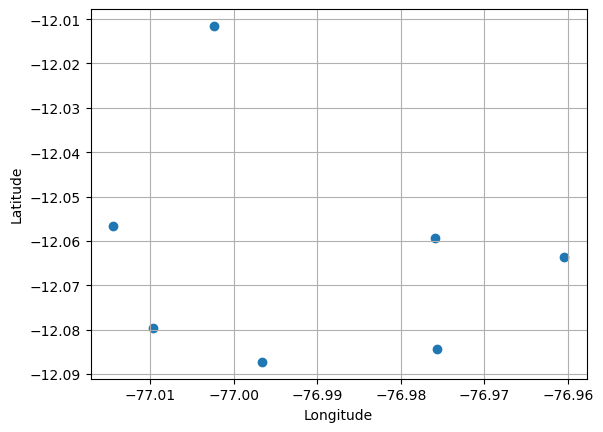

In [4]:
plt.scatter(df.x, df.y)

plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.grid()
plt.show()

In [21]:
## Make Distance Matrix
points = df.values
n = len(points)
C = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C[i,j] = cdist(np.array(points[i]).reshape(1,-1), np.array(points[j]).reshape(1,-1)).ravel()
X = cp.Variable(C.shape, boolean=True)
u = cp.Variable(n, integer=True)
ones = np.ones((n,1))

C:\Users\Admin\AppData\Local\Temp\ipykernel_21820\1235764052.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C[i,j] = cdist(np.array(points[i]).reshape(1,-1), np.array(points[j]).reshape(1,-1)).ravel()


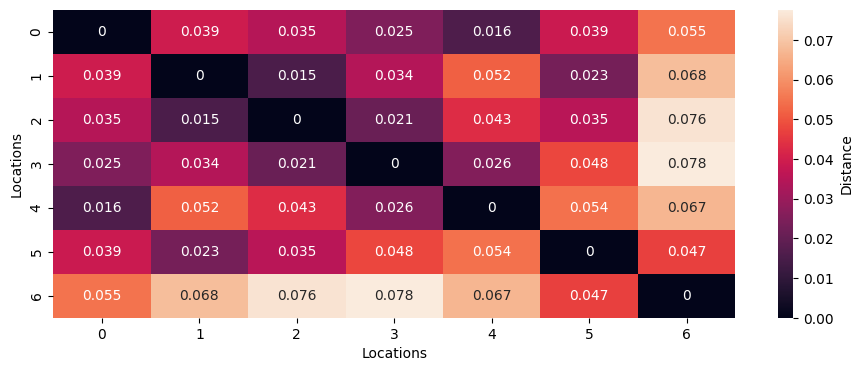

In [6]:
plt.figure(figsize=(11,4))

sns.heatmap(C, annot=True, cbar_kws={'label': 'Distance'})
plt.xlabel('Locations')
plt.ylabel('Locations')
plt.show()

## Classical Objective Function

In [22]:
# Defining the objective function
objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

## Classiccal Constraints

In [23]:
# Defining the constraints
constraints = []
constraints += [X @ ones == ones]
constraints += [X.T @ ones == ones]
constraints += [cp.diag(X) == 0]

# No subtour constraint! (Subtour Elimination)
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            constraints += [u[i] - u[j] + 1  <= (n - 1) * (1 - X[i, j])]

## Classical Solution

In [24]:
# Solving the problem
prob = cp.Problem(objective, constraints)
prob.solve(verbose=False)

# Transforming the solution to a path
X_sol = np.argwhere(X.value==1)
orden = X_sol[0].tolist()
for i in range(1, n):
    row = orden[-1]
    orden.append(X_sol[row,1])

In [25]:
orden

[0, 6, 5, 1, 2, 3, 4, 0]

<Axes: >

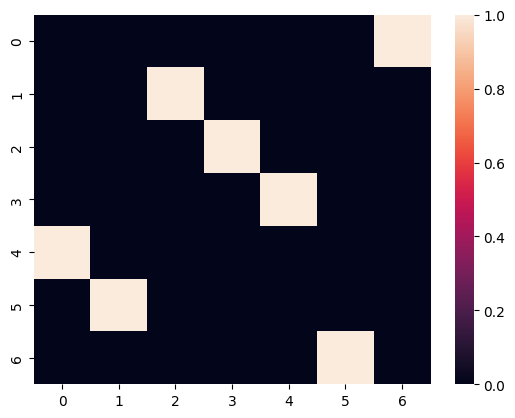

In [26]:
sns.heatmap(X.value)

In [27]:
def tsp_plotter(points, soln):
    fig, ax = plt.subplots(2, sharex=True, sharey=True)         # Prepare 2 plots
    ax[0].set_title('Raw nodes')
    ax[1].set_title('Optimized tour')
    ax[0].scatter(points[:, 0], points[:, 1])             # plot A
    ax[1].scatter(points[:, 0], points[:, 1])             # plot B
    start_node = 0
    distance = 0.
    N = points.shape[0]
    for i in range(1,N+1):
        start_pos = points[start_node]
        next_node = soln[i] # needed because of MIP-approach used for TSP
        end_pos = points[next_node]
        ax[1].annotate("",
                xy=start_pos, xycoords='data',
                xytext=end_pos, textcoords='data',
                arrowprops=dict(arrowstyle="<-",
                                connectionstyle="arc3"))
        distance += np.linalg.norm(end_pos - start_pos)
        start_node = next_node
    
    textstr = "N nodes: %d\nTotal length: %.3f" % (N, distance)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[1].text(0.7, 0.95, textstr, transform=ax[1].transAxes, fontsize=11, # Textbox
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()

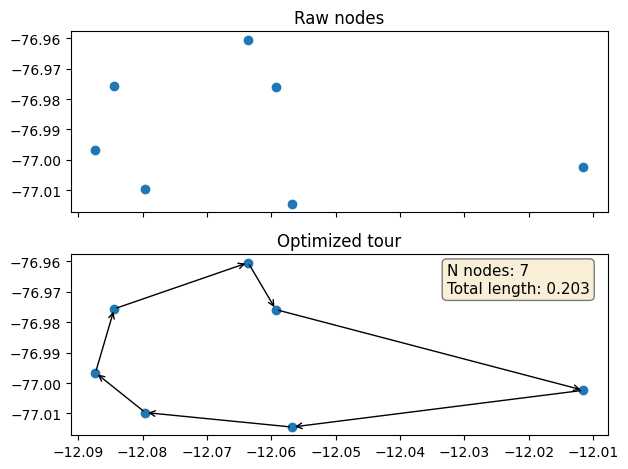

In [28]:
tsp_plotter(points, orden)

# QUBO Reformulation

$$
\begin{align}
\min & Q = \sum_{i=1}^n \sum_{j\ne i,j=1}^n c_{i,j}x_{i,j}\colon &&  \\
     & P_1 = \left(\sum_{i=1,i\ne j}^n x_{i,j} -1 \right)^2 \\
     & P_2 = \left(\sum_{j=1,j\ne i}^n x_{i,j} -1\right)^2\\
\end{align}
$$

In [29]:
from pyqubo import Binary, Array, Constraint, Placeholder
import neal
from tqdm import tqdm 

## Variables

In [30]:
## decision whether to go to that location or not
X = Array.create('x', shape=(n, n), vartype='BINARY')

## QUBO Objective Function

In [31]:
c = Array(C)

In [32]:
Q = 0.0
subh = c @ X
for h in subh:
    Q += h[0]
Q

(((0.000000 * Binary('x[6][0]')) + (0.046814 * Binary('x[5][0]')) + (0.066836 * Binary('x[4][0]')) + (0.077609 * Binary('x[3][0]')) + (0.075991 * Binary('x[2][0]')) + (0.068435 * Binary('x[1][0]')) + 0.000000 + (0.054619 * Binary('x[0][0]'))) + ((0.046814 * Binary('x[6][0]')) + (0.000000 * Binary('x[5][0]')) + (0.054401 * Binary('x[4][0]')) + (0.047633 * Binary('x[3][0]')) + (0.035366 * Binary('x[2][0]')) + (0.023306 * Binary('x[1][0]')) + 0.000000 + (0.038642 * Binary('x[0][0]'))) + ((0.066836 * Binary('x[6][0]')) + (0.054401 * Binary('x[5][0]')) + (0.000000 * Binary('x[4][0]')) + (0.025733 * Binary('x[3][0]')) + (0.043215 * Binary('x[2][0]')) + (0.051730 * Binary('x[1][0]')) + 0.000000 + (0.016001 * Binary('x[0][0]'))) + ((0.077609 * Binary('x[6][0]')) + (0.047633 * Binary('x[5][0]')) + (0.025733 * Binary('x[4][0]')) + (0.000000 * Binary('x[3][0]')) + (0.021170 * Binary('x[2][0]')) + (0.034374 * Binary('x[1][0]')) + 0.000000 + (0.025096 * Binary('x[0][0]'))) + ((0.075991 * Binary('x[

## QUBO Constraints

In [33]:
P1 = 0.0
for i in range(n):
    # If you wrap the hamiltonian by Const(...), this part is recognized as constraint
    P1 += Constraint((sum(X[i, j] for j in range(n)) - 1)**2, label="p1{}".format(i))

# Constraint not to visit the same city more than twice.
P2 = 0.0
for j in range(n):
    P2 += Constraint((sum(X[i, j] for i in range(n)) - 1)**2, label="p2{}".format(j))

In [34]:
P3 = Constraint(np.diag(X).sum()**2, label='trace')

## Quantum (inspired) Optimization

In [35]:
H = Q + P1 + P2 + P3
model = H.compile()

In [36]:
bqm = model.to_bqm()

In [37]:
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=200, sweeps=100
                               , beta_range=(1, 100.0)
                               )

In [38]:
dec_samples = model.decode_sampleset(sampleset)

In [39]:
best = min(dec_samples, key=lambda x: x.energy).sample

In [40]:
X_qsoln = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        X_qsoln[i,j] = best[f'x[{i}][{j}]']
        

<Axes: >

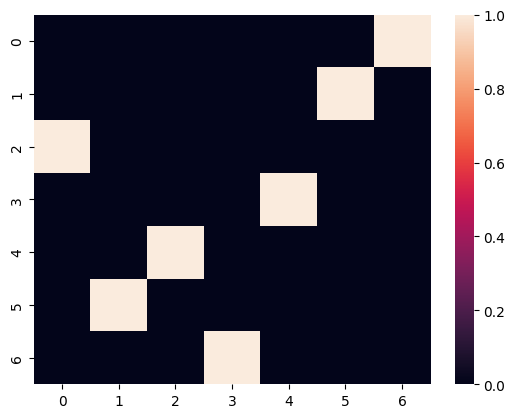

In [41]:
sns.heatmap(X_qsoln)

In [42]:
path = np.argwhere(X_qsoln==1)
orden = path[0].tolist()
for i in range(1, n):
    row = orden[-1]
    orden.append(path[row,1])

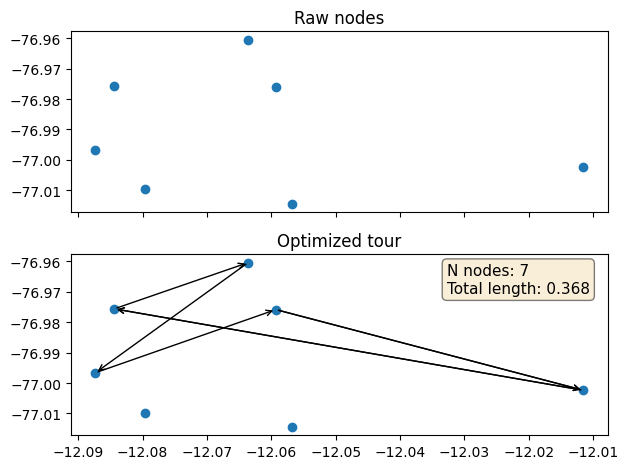

In [43]:
tsp_plotter(points, orden)

## Add Lagrangians

In [44]:
a = Placeholder("a")
b = Placeholder("b")
H = Q + a * (P1+P2) + b*P3

In [49]:
feed_dict = {'a': 5.0, 'b': 4.0,}
bqm = model.to_bqm(feed_dict=feed_dict)

In [50]:
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=200, num_sweeps=100)

# Decode solution
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
best_sample = min(decoded_samples, key=lambda x: x.energy)
num_broken = len(best_sample.constraints(only_broken=True))
print("number of broken constraint = {}".format(num_broken))

number of broken constraint = 0


In [51]:
if num_broken == 0:
    X_qsoln = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            X_qsoln[i,j] = best_sample.sample[f'x[{i}][{j}]']
path = np.argwhere(X_qsoln==1)
orden = path[0].tolist()
for i in range(1, n):
    row = orden[-1]
    orden.append(path[row,1])

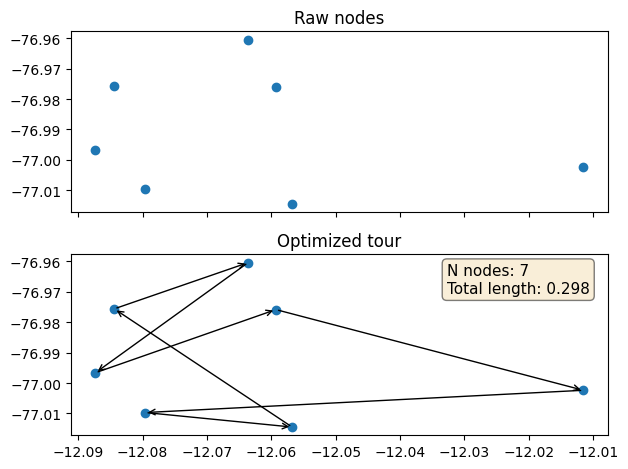

In [52]:
tsp_plotter(points, orden)

<Axes: >

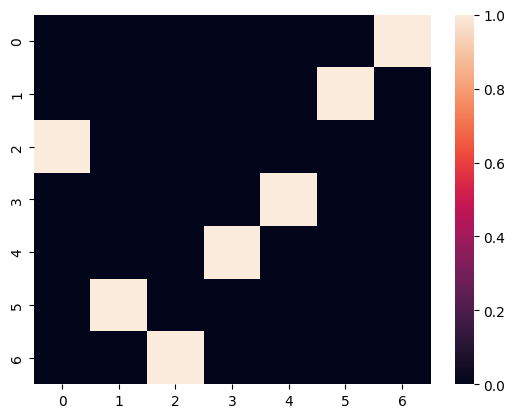

In [50]:
sns.heatmap(X_qsoln)

## Subtour Elimination